In [23]:
import distiller 
import numpy as np
import os, collections
import bitstring 
import time 
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F

import models 
from matplotlib import pyplot as plt
# import multiprocessing 
%matplotlib inline

print('using GPU:', torch.cuda.is_available())

using GPU: True


In [24]:
test_batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=test_batch_size, shuffle=False, **kwargs)

def load_checkpoint(model_path):
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model)
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            raise ValueError("=> no checkpoint found at '{}'".format(model_path))
    else:
        raise ValueError('args.model cannot be empty!')
    return best_prec1 

def test():
    model.eval()
    model.cuda()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [25]:
model_path = "/home/hguan2/workspace/fault-tolerance/rethinking-network-pruning/cifar/l1-norm-pruning"+ \
    "/logs/resnet56/cifar10/model_best.pth.tar"
arch = 'resnet'
depth = 56
dataset = 'cifar10'

checkpoint = torch.load(model_path)
model = models.__dict__[arch](dataset=dataset, depth=depth, cfg=checkpoint['cfg'])
model.load_state_dict(checkpoint['state_dict'])
best_prec1 = checkpoint['best_prec1']
print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
# print(model)

=> loaded checkpoint '/home/hguan2/workspace/fault-tolerance/rethinking-network-pruning/cifar/l1-norm-pruning/logs/resnet56/cifar10/model_best.pth.tar' (epoch 134) Prec1: 0.926900


In [26]:
#for param_name, param in model.named_parameters():
#    if len(param.size()) < 2:
#        continue
#    plt.hist(param.data.cpu().numpy().ravel(), bins=100)
#    plt.title(param_name + ': '+ str(param.size()))
#    plt.show()

In [27]:
#model_size = 0 
#for name, param in model.named_parameters():
#    print(name, param.data.size())
#    model_size += param.data.nelement()
#print('model size:', model_size)

In [28]:
# post train quantization 
quantizer = distiller.quantization.PostTrainLinearQuantizer(model)
quantizer.prepare_model()

In [29]:
prec1 = test()

Test set: Average loss: 0.365515, Accuracy: 9264/10000 (92.64%)


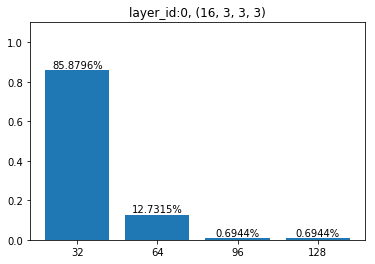

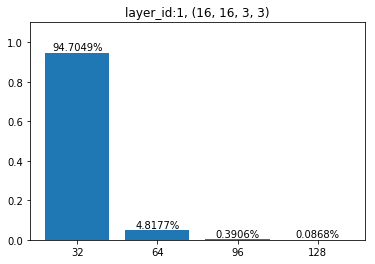

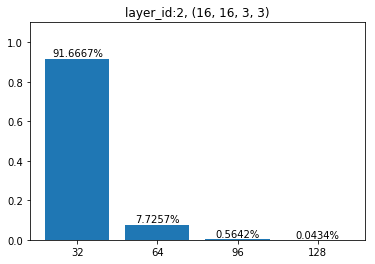

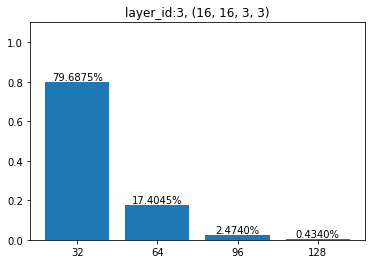

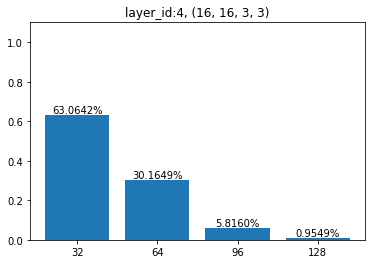

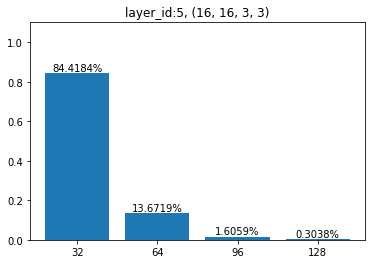

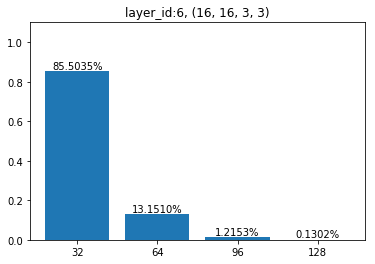

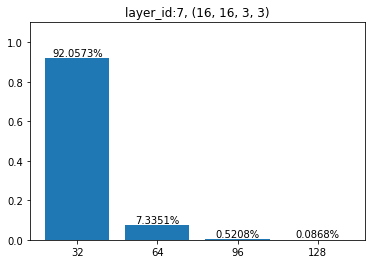

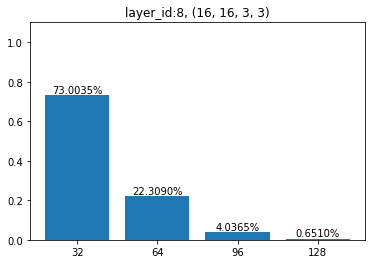

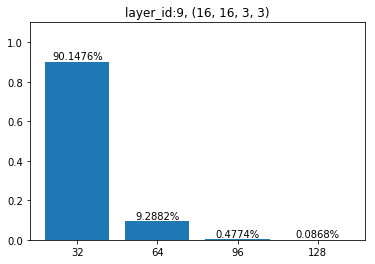

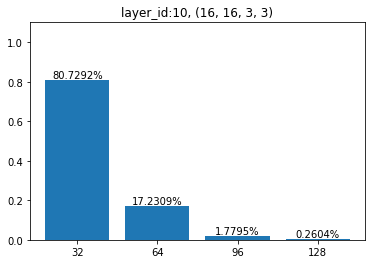

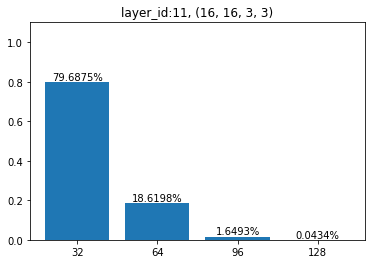

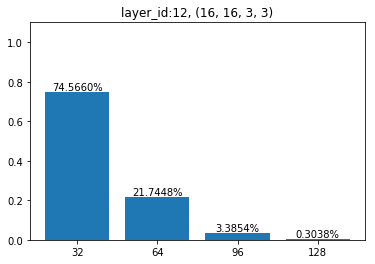

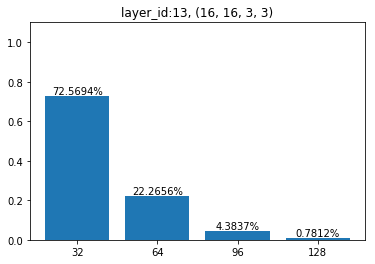

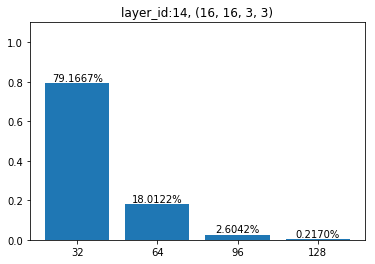

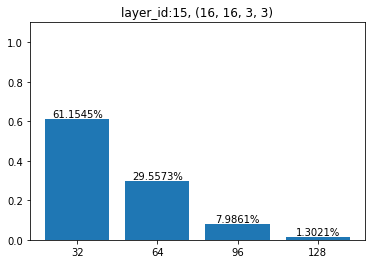

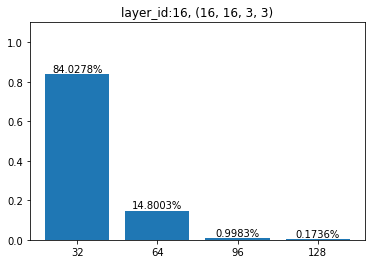

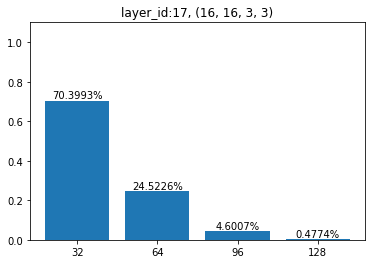

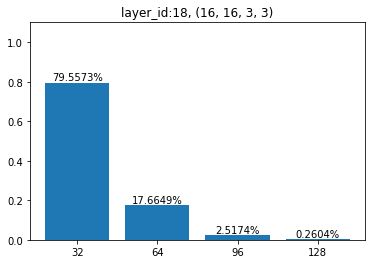

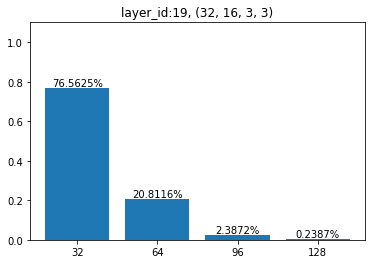

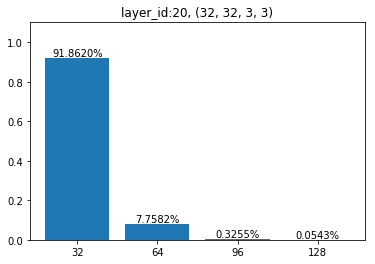

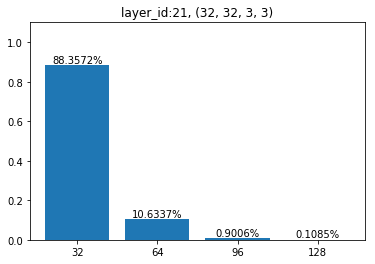

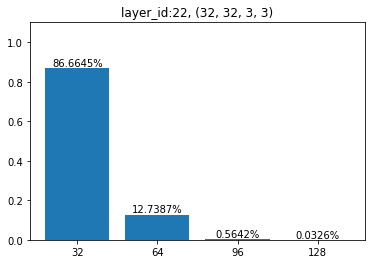

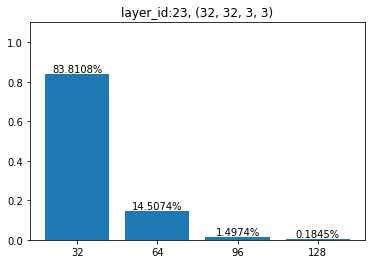

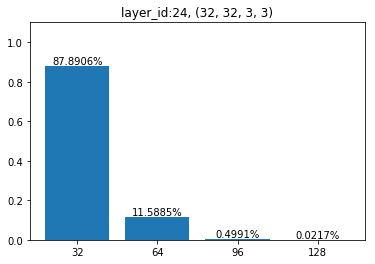

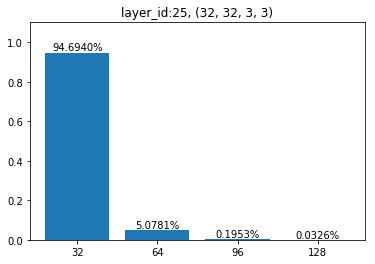

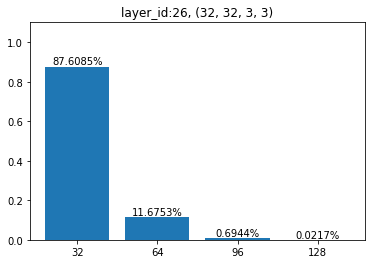

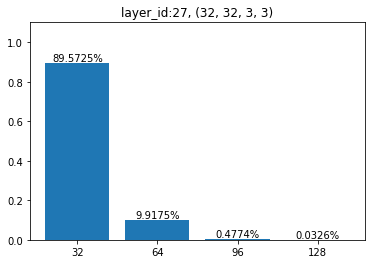

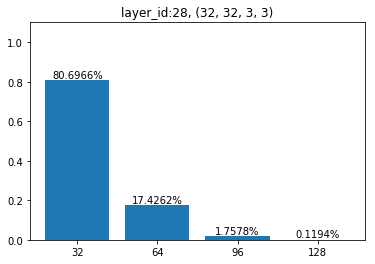

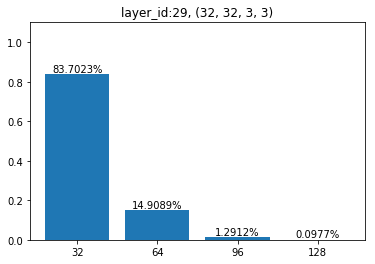

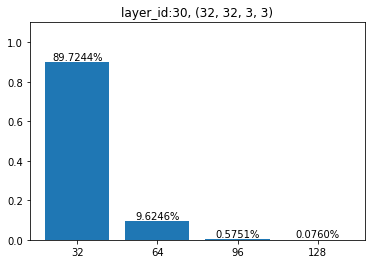

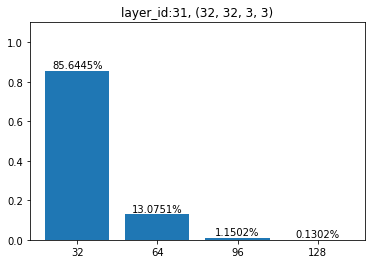

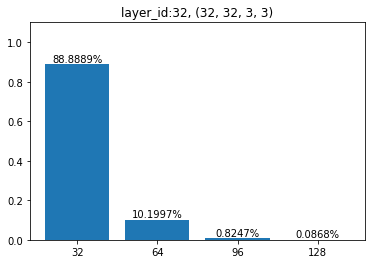

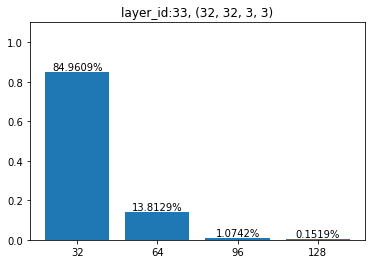

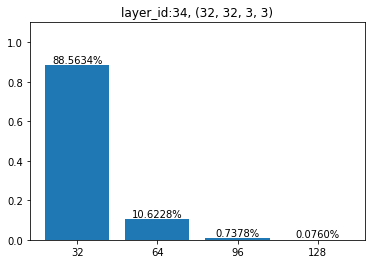

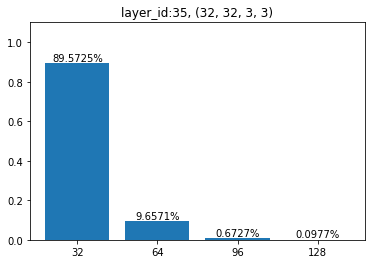

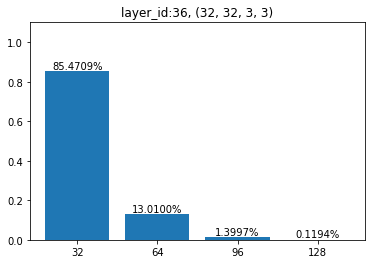

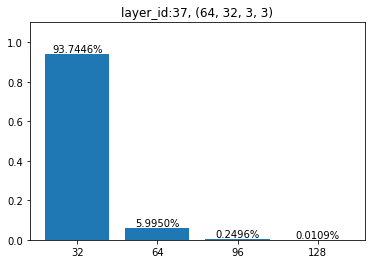

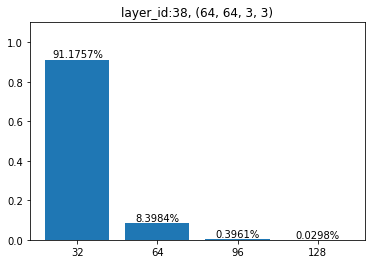

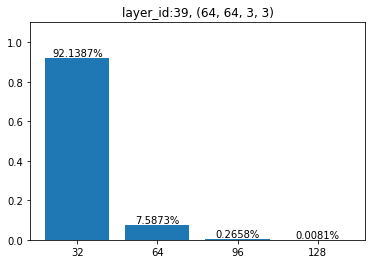

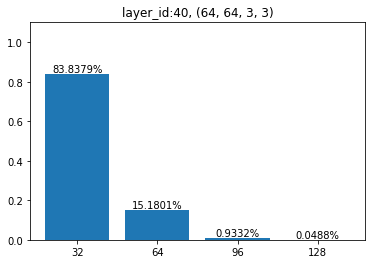

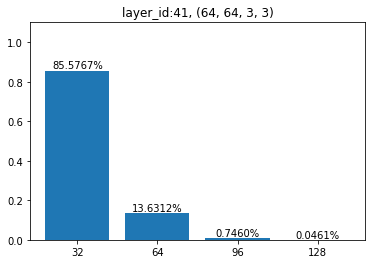

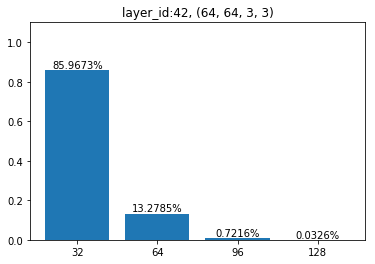

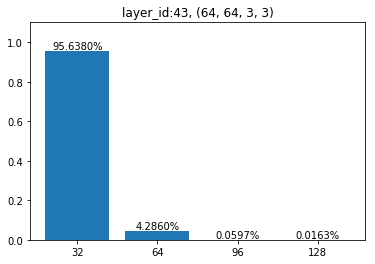

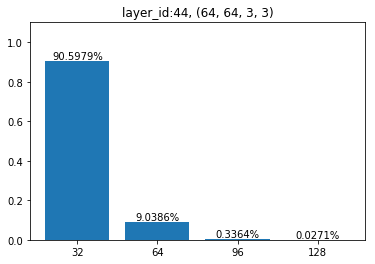

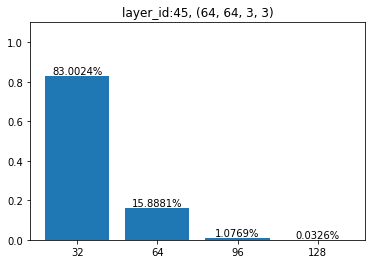

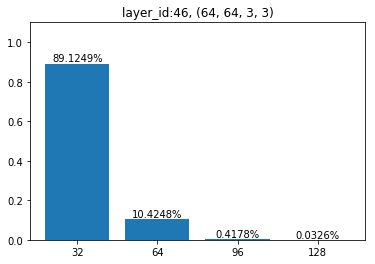

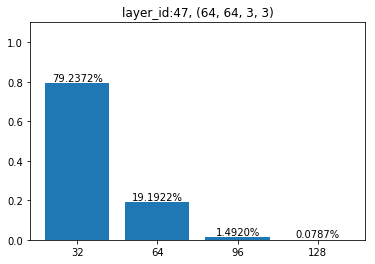

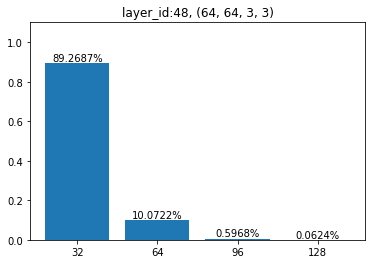

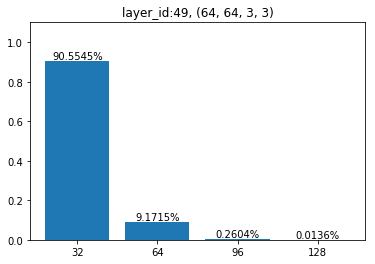

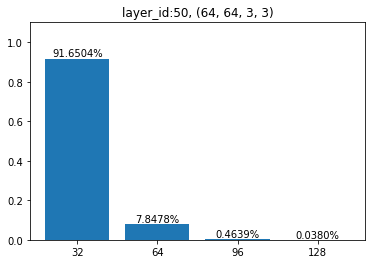

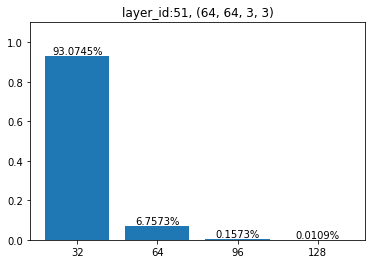

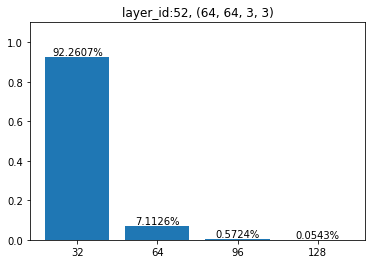

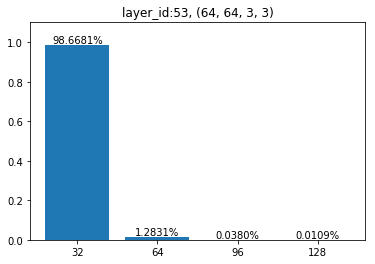

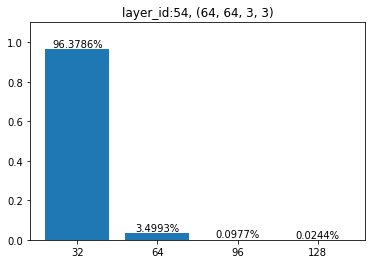

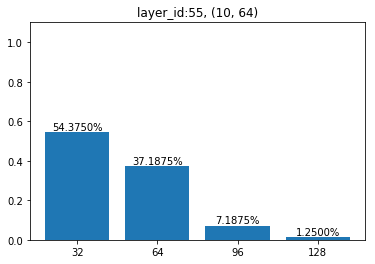

In [30]:
# check the distribution of parameters 
thr = 32
layer_id = 0 
for param_name, param in model.named_parameters():
    if len(param.size()) < 2:
        continue
    counter = collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr)
    tmp = sorted(counter.items(), key=lambda x: x[0])
    values, counts = zip(*tmp)
    percentages = [count/sum(list(counts)) for count in counts]
    bar = plt.bar(values, percentages)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
#     print(['%.2f' %(p) for p in percentages])
    #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
    plt.xticks(values, [str(int(v)*thr+thr) for v in values])
    plt.title('layer_id:'+str(layer_id) + ', '+ str(tuple(param.size())))
#     plt.grid()
    plt.ylim(0, 1.1)
    plt.show()
    layer_id += 1

In [20]:
# check bit copy model-wise 

def get_copy_bits_fn(n_LSB=1):
    assert 0 < n_LSB < 5 
    print('Copy n_LSB:', n_LSB)
    def copy_bits(v):
        bits = bitstring.pack('>b', v)
        # print('befor, bits:', bits.bin, bits.int)
        bits[8-n_LSB:8] = bits[:n_LSB]
        # print('after, bits:', bits.bin, bits.int)
        return bits.int
    return copy_bits 
    

for n_LSB in [4]: #[1, 2, 3]:
    copy_bits = get_copy_bits_fn(n_LSB)

    start = time.time()
    for name, param in model.named_parameters():
        if len(param.size()) < 2:
            continue
        tensor = param.data.cpu()
        tensor_shape = tensor.size()
        tensor_1d = tensor.numpy().ravel()
    #     print('befor:', tensor_1d)
        tensor_1d = np.asarray([copy_bits(v) for v in tensor_1d], dtype='float32')
        #print('after:', tensor_1d)
        param.data = torch.from_numpy(np.reshape(tensor_1d, tensor_shape))
        #print('after:', param.data.view(-1))
        print('Finish parameter:', name, str(param.size()))
    end = time.time()
    print("elapsed time: %f(min)" %((end-start)/60))
    # test accuracy
    prec1 = test()



Copy n_LSB: 4
Finish parameter: conv1.wrapped_module.weight torch.Size([16, 3, 3, 3])
Finish parameter: layer1.0.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.0.conv2.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.1.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.1.conv2.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.2.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.2.conv2.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.3.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.3.conv2.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.4.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.4.conv2.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish parameter: layer1.5.conv1.wrapped_module.weight torch.Size([16, 16, 3, 3])
Finish param

In [52]:
# check bit copy per layer 

def get_copy_bits_fn(n_LSB=1):
    assert 0 < n_LSB < 5 
#     print('Copy n_LSB:', n_LSB)
    def copy_bits(v):
        bits = bitstring.pack('>b', v)
        # print('befor, bits:', bits.bin, bits.int)
        bits[8-n_LSB:8] = bits[:n_LSB]
        # print('after, bits:', bits.bin, bits.int)
        return bits.int
    return copy_bits 

def write_log(info, mode='a'):
    with open('./tmp/check_quantized_bit_copy_layerwise_resnet56.txt', mode) as f:
        f.write(info+'\n')
        
info = "%s\t %s\t %s\t %s\t %s\t" %("name", "tensor_shape", "n_LSB", "prec1", "total_time")
write_log(info, mode='w')

for name, param in model.named_parameters():
    if len(param.size()) < 2:
        continue
    
    tensor_copy = param.data.clone() 
    tensor_shape = param.data.size()
    
    
    for n_LSB in [1, 2, 3, 4]:
        start = time.time()
        
        copy_bits = get_copy_bits_fn(n_LSB)
        tensor_1d = param.data.cpu().numpy().ravel()
        # print('befor:', tensor_1d)
        tensor_1d = np.asarray([copy_bits(v) for v in tensor_1d], dtype='float32')
        # print('after:', tensor_1d)
        param.data = torch.from_numpy(np.reshape(tensor_1d, tensor_shape))
        # print('after:', param.data.view(-1))
        
        # test accuracy
        prec1 = test()
        
        # recover the param
        param.data = tensor_copy
    
        end = time.time()
        total_time = (end-start)/60
        info = "%s\t %s\t %s\t %s\t %s\t" %(name, tuple(tensor_shape), n_LSB, prec1, total_time)
        print(info)
        write_log(info)

    


Test set: Average loss: 0.3166, Accuracy: 9382/10000 (93.82%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 1	 0.9382	 0.043767849604288735	
Test set: Average loss: 0.3220, Accuracy: 9358/10000 (93.58%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 2	 0.9358	 0.04476538896560669	
Test set: Average loss: 0.3367, Accuracy: 9320/10000 (93.20%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 3	 0.932	 0.04483282168706258	
Test set: Average loss: 0.4415, Accuracy: 9098/10000 (90.98%)
feature.0.wrapped_module.weight	 (64, 3, 3, 3)	 4	 0.9098	 0.043702284495035805	
Test set: Average loss: 0.3171, Accuracy: 9375/10000 (93.75%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 1	 0.9375	 0.10916215976079305	
Test set: Average loss: 0.3291, Accuracy: 9355/10000 (93.55%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 2	 0.9355	 0.11194942394892375	
Test set: Average loss: 0.4153, Accuracy: 9162/10000 (91.62%)
feature.3.wrapped_module.weight	 (64, 64, 3, 3)	 3	 0.9162	 0.1102660576502482	
Tes

Test set: Average loss: 0.2946, Accuracy: 9374/10000 (93.74%)
classifier.3.wrapped_module.weight	 (10, 512)	 3	 0.9374	 0.053039737542470294	
Test set: Average loss: 0.2723, Accuracy: 9378/10000 (93.78%)
classifier.3.wrapped_module.weight	 (10, 512)	 4	 0.9378	 0.0491856853167216	


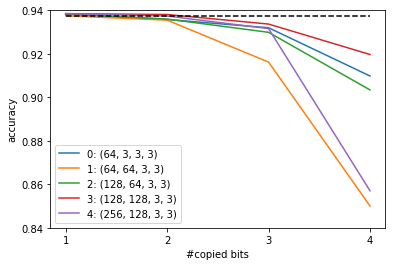

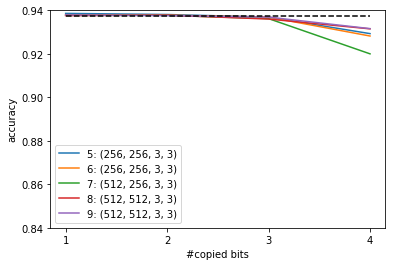

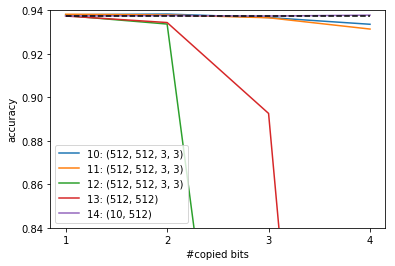

In [72]:
def read_log():
    data = [] 
    with open('./tmp/check_quantized_bit_copy_layerwise.txt', 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:

            name, tensor_shape, n_LSB, prec1, *arg = line.split('\t')
            n_LSB, prec1 = int(n_LSB), float(prec1)
            if data and data[-1]["name"] == name:
                data[-1]["res"].append((n_LSB, prec1))
            else:
                data.append({'name': name, 'tensor_shape': tensor_shape, 'res': [(n_LSB, prec1)]})
    return data 
results = read_log()

for i in range(len(results)):
    n_LSBs, accuracies = zip(*results[i]['res'])
    plt.plot(n_LSBs, accuracies, label=str(i)+':'+results[i]["tensor_shape"])
    if (i+1)%5 == 0 or i == len(results)-1:
        plt.legend()
        plt.plot(n_LSBs, [0.9375]*len(n_LSBs), 'k--')
        plt.ylim(0.84, 0.94)
        plt.xlabel('#copied bits')
        plt.ylabel('accuracy')
        plt.xticks(n_LSBs, [str(x) for x in n_LSBs])
        plt.show()
            
                
            

feature.0.wrapped_module.weight torch.Size([64, 3, 3, 3])


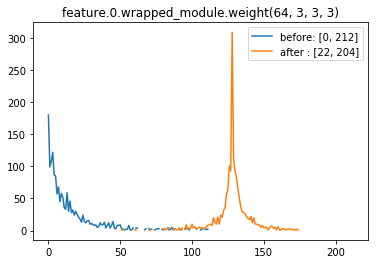

feature.3.wrapped_module.weight torch.Size([64, 64, 3, 3])


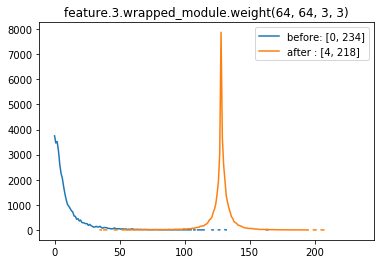

feature.7.wrapped_module.weight torch.Size([128, 64, 3, 3])


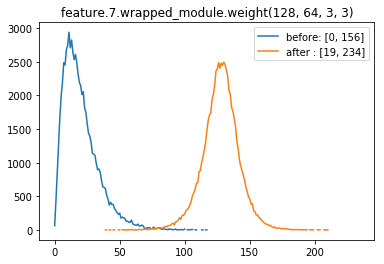

feature.10.wrapped_module.weight torch.Size([128, 128, 3, 3])


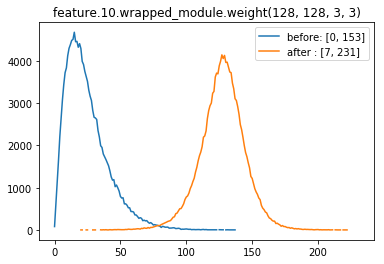

feature.14.wrapped_module.weight torch.Size([256, 128, 3, 3])


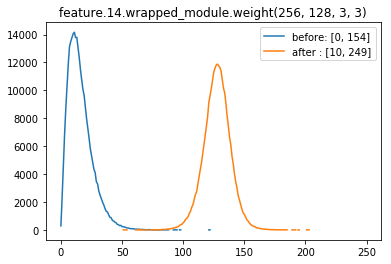

feature.17.wrapped_module.weight torch.Size([256, 256, 3, 3])


KeyboardInterrupt: 

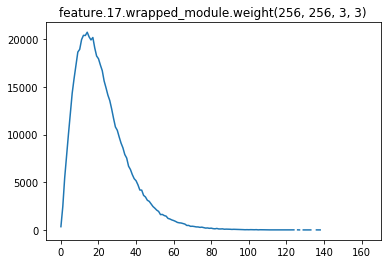

In [11]:
# check locality 

def flip_one_bit(bit_position):
    assert 0 <= bit_position <= 7
    def helper1(v):
        bits = bitstring.pack('>b', v)
        bits[bit_position] ^= 1
        return bits.int 
    def helper2(v):
        offset = [128, 64, 32, 16][bit_position]
        if v < 0:
            v = v + offset 
        else:
            v = v - offset 
        return v 
    return helper1, helper2 

bit_position = 0
_, flip = flip_one_bit(bit_position)
# print(flip1(-128), flip2(-128))

# w1, w2, w3; locality(w2) = max(|w2-w1|, |w2-w3|)
for name, param in model.named_parameters():
    
    # only consider weights 
    if len(param.size()) < 2:
        continue 
    print(name, param.size())
    tensor_1d = param.data.cpu().numpy().ravel()
    left = np.concatenate((tensor_1d[:1], tensor_1d[:-1]), axis=0)
    right = np.concatenate((tensor_1d[1:], tensor_1d[-1:]), axis=0)
    locality = collections.Counter(np.maximum(np.abs(tensor_1d - left), np.abs(tensor_1d - right)))

    diffs = locality.keys()
    plt.plot(range(256), [locality.get(x) for x in range(256)], 
             label='before: [%d, %d]' %(min(diffs), max(diffs)))
#     plt.ylim(0, 256)
    plt.title(name + str(tuple(param.size())))

    
    # after sign bit flipped
    tensor_1d_flipped = np.array([flip(v) for v in tensor_1d])
    locality = collections.Counter(np.maximum(np.abs(tensor_1d_flipped - left), np.abs(tensor_1d_flipped - right)))
    diffs = locality.keys()
    plt.plot(range(256), [locality.get(x) for x in range(256)], 
             label='after : [%d, %d]' %(min(diffs), max(diffs)))
#     plt.title('flip bit_pos:'+ str(bit_position)) 
#     plt.ylim(0, 256)
    plt.legend()
    plt.show()

    
    

In [54]:
# check data reorganization 
bit_counter = [[] for _ in range(8)]
value_count = 0 
start = time.time()
for name, param in model.named_parameters():
    # ignore batch normalization layer 
    if len(param.data.size()) < 2:
        continue 
    tensor = param.data.cpu().numpy().ravel()
    value_count += len(tensor)
    for v in tensor:
        bits = bitstring.pack('>b', v)
        for i in range(8):
            bit_counter[i] += bits[i],
    print('Finish parameter:', name, str(param.size()))
end = time.time()
print('Elasped in: %s(s)' %(end-start))
print('value_count:', value_count)

Finish parameter: feature.0.wrapped_module.weight torch.Size([64, 3, 3, 3])
Finish parameter: feature.3.wrapped_module.weight torch.Size([64, 64, 3, 3])
Finish parameter: feature.7.wrapped_module.weight torch.Size([128, 64, 3, 3])
Finish parameter: feature.10.wrapped_module.weight torch.Size([128, 128, 3, 3])
Finish parameter: feature.14.wrapped_module.weight torch.Size([256, 128, 3, 3])
Finish parameter: feature.17.wrapped_module.weight torch.Size([256, 256, 3, 3])
Finish parameter: feature.20.wrapped_module.weight torch.Size([256, 256, 3, 3])
Finish parameter: feature.24.wrapped_module.weight torch.Size([512, 256, 3, 3])
Finish parameter: feature.27.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.30.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.34.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.37.wrapped_module.weight torch.Size([512, 512, 3, 3])
Finish parameter: feature.40.wrapped_module.weigh

Text(0,0.5,'1 count')

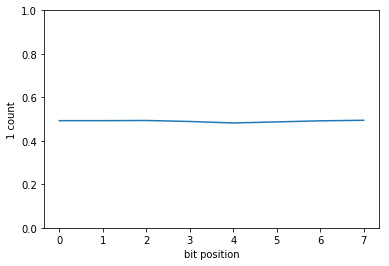

In [53]:
plt.plot([x*1.0/value_count for x in bit_counter])
plt.ylim(0, 1)
plt.xlabel('bit position')
plt.ylabel('1 count')

In [9]:
# for key, value in model.state_dict().items():
#     print(key, value)

feature.0.w_scale tensor([61.5932], device='cuda:0')
feature.0.w_zero_point tensor([0.], device='cuda:0')
feature.0.wrapped_module.weight tensor([[[[ 11.,   6.,   5.],
          [ -3., -15.,   3.],
          [-12., -27.,   0.]],

         [[ 15.,  10.,   5.],
          [  6.,  -6.,   6.],
          [ -4., -18.,   4.]],

         [[ 13.,   9.,   5.],
          [  4.,  -6.,   4.],
          [ -9., -21.,  -0.]]],


        [[[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,  -0.]],

         [[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,  -0.,  -0.]],

         [[  0.,   0.,   0.],
          [  0.,   0.,   0.],
          [  0.,   0.,   0.]]],


        [[[ -5.,  -7., -10.],
          [ -8., -12., -13.],
          [-14., -20., -19.]],

         [[ 14.,  21.,  11.],
          [ 19.,  26.,  17.],
          [  8.,  11.,   7.]],

         [[ -2.,  -1.,  -2.],
          [ -6.,  -7.,  -5.],
          [-10., -16., -11.]]],


        ...,


        [[[ 1

feature.11.running_var tensor([0.8655, 1.5239, 1.0462, 1.0904, 1.4366, 0.9376, 1.2645, 1.2422, 0.8515,
        1.3387, 0.7903, 1.1806, 1.1337, 1.3526, 1.6286, 0.9742, 1.2678, 1.2012,
        1.0838, 1.2686, 0.9334, 1.3073, 1.1301, 1.3578, 1.3769, 0.9823, 1.0338,
        0.8071, 1.1952, 1.8760, 0.8078, 1.0719, 0.8234, 0.8768, 1.6753, 1.0220,
        1.2237, 1.1495, 1.6389, 0.9956, 1.0831, 1.2200, 1.2970, 0.7300, 1.4885,
        1.0419, 1.2529, 1.4873, 1.3616, 0.9862, 1.6482, 1.7884, 1.5337, 1.1744,
        0.7961, 0.7982, 0.8284, 1.3512, 1.0901, 1.3612, 1.3598, 1.3466, 1.6939,
        0.7305, 1.3595, 1.6649, 1.1555, 1.0082, 1.4235, 1.1052, 1.0848, 1.1157,
        1.5820, 1.1676, 1.2123, 1.1136, 0.8393, 1.0725, 1.2169, 1.7648, 1.1654,
        1.1289, 0.9872, 1.2039, 1.2502, 1.4084, 1.3479, 1.2505, 0.9472, 1.2009,
        1.3818, 1.2318, 0.9034, 0.6187, 1.0360, 0.9598, 1.1432, 0.9691, 1.0656,
        1.0212, 1.0138, 1.2213, 1.3131, 1.2526, 1.0753, 1.1833, 1.5868, 1.0083,
        1.1480, 1

feature.15.running_var tensor([0.7489, 1.0329, 1.0587, 1.5360, 0.9220, 1.3156, 1.1152, 1.5876, 1.1504,
        0.9711, 0.8584, 1.2650, 1.4948, 1.0020, 1.2032, 1.0618, 1.4003, 1.0909,
        0.9048, 1.5176, 1.0104, 0.9194, 0.8401, 1.0543, 1.3335, 0.9812, 1.7323,
        1.3273, 0.9584, 0.8164, 1.0828, 0.7157, 1.7383, 0.9941, 0.8869, 0.9226,
        0.9452, 1.0803, 1.5143, 1.2097, 0.9909, 0.9512, 0.7111, 1.1766, 1.3908,
        0.8108, 1.2266, 0.9332, 0.9007, 0.7931, 1.2144, 1.5479, 1.0824, 2.0300,
        0.9029, 0.8898, 1.2164, 1.0378, 1.2513, 1.1071, 1.2034, 0.9343, 1.0029,
        1.4644, 1.2180, 1.0324, 0.9958, 1.4828, 0.8356, 1.2067, 1.2014, 0.8892,
        1.2065, 1.0189, 1.4891, 1.0926, 1.3372, 1.1429, 0.9324, 0.9486, 1.0812,
        0.9353, 1.0050, 1.0531, 1.3480, 1.3615, 0.8962, 0.9526, 0.9396, 1.3503,
        1.4622, 1.0427, 0.9968, 0.9410, 1.5841, 1.3576, 0.8858, 2.1665, 1.1109,
        1.1504, 0.8795, 1.1439, 1.0986, 1.3634, 1.0123, 0.7592, 1.2939, 0.8266,
        1.0056, 0

feature.25.weight tensor([0.2678, 0.1539, 0.2975, 0.1453, 0.1764, 0.3682, 0.1156, 0.2001, 0.2242,
        0.3469, 0.2026, 0.2250, 0.1734, 0.1759, 0.1262, 0.2886, 0.1020, 0.2396,
        0.2521, 0.3423, 0.2626, 0.2212, 0.1293, 0.1531, 0.4284, 0.2602, 0.1870,
        0.2346, 0.2443, 0.2166, 0.2476, 0.1783, 0.2569, 0.3410, 0.2487, 0.2466,
        0.3016, 0.2726, 0.0912, 0.3628, 0.1491, 0.0992, 0.2528, 0.3807, 0.2010,
        0.2400, 0.3022, 0.2231, 0.2249, 0.1854, 0.2999, 0.2323, 0.2167, 0.1879,
        0.3498, 0.2916, 0.2278, 0.2706, 0.2581, 0.3780, 0.2844, 0.1880, 0.2212,
        0.1487, 0.2508, 0.2492, 0.1823, 0.1985, 0.1992, 0.1796, 0.1852, 0.4575,
        0.2953, 0.2330, 0.2035, 0.3216, 0.2110, 0.1980, 0.4228, 0.1690, 0.2941,
        0.2046, 0.1716, 0.1984, 0.1512, 0.2646, 0.2863, 0.3606, 0.2576, 0.4323,
        0.1713, 0.2526, 0.2166, 0.1879, 0.3084, 0.2323, 0.3170, 0.2023, 0.3466,
        0.2120, 0.2508, 0.1818, 0.3570, 0.2981, 0.1991, 0.1707, 0.3202, 0.1754,
        0.3099, 0.2323

feature.27.wrapped_module.weight tensor([[[[ 13.,   5.,   4.],
          [ -1.,  -7.,   3.],
          [-11.,  -4.,  -4.]],

         [[ -7.,  -4.,  -3.],
          [-11., -13.,  -3.],
          [  8.,  13.,   8.]],

         [[  7.,  -9.,  -7.],
          [ -3.,  -9.,  -5.],
          [ -2., -12.,  -9.]],

         ...,

         [[-10.,   8.,  15.],
          [  3.,  23.,  21.],
          [ 12.,  19.,  -1.]],

         [[  9.,   3.,   7.],
          [  6.,  13.,  13.],
          [ -8.,   4.,   9.]],

         [[  1., -13.,  -2.],
          [ -6., -21.,  10.],
          [ -6., -18.,  -4.]]],


        [[[ 37.,   3.,   6.],
          [ 47.,  14.,   9.],
          [ 28.,  17.,  13.]],

         [[  2.,  10.,  11.],
          [-16., -10.,  -2.],
          [ -1., -12., -11.]],

         [[ 10.,  16.,  20.],
          [  3.,  -7.,   7.],
          [ -5.,  -2.,   4.]],

         ...,

         [[ -1.,  -8.,  -3.],
          [ -1.,  -8.,  -5.],
          [ -6., -20., -15.]],

         [[-13.

feature.34.wrapped_module.weight tensor([[[[  2., -14.,  11.],
          [ 14., -19.,   8.],
          [ -6.,   7.,  -7.]],

         [[  3.,  -3.,  -3.],
          [  4.,   2.,   1.],
          [ -4.,   3.,  -3.]],

         [[ 12.,  13., -13.],
          [-31.,  12.,  -5.],
          [  3., -24.,  -3.]],

         ...,

         [[  3.,  -7.,  -2.],
          [ -1., -32.,  11.],
          [-11.,  -1.,   0.]],

         [[  1.,  -6.,   4.],
          [  0.,   3., -15.],
          [ -3.,  -1.,  -3.]],

         [[ 14.,  -9.,   9.],
          [  7., -23.,   0.],
          [ -4.,  10., -13.]]],


        [[[-24.,  31., -10.],
          [-14.,  14., -14.],
          [ -0.,   7.,  -1.]],

         [[ -2.,   6.,  11.],
          [ 10., -14.,  -8.],
          [  4.,   5.,   4.]],

         [[  8., -25.,  -5.],
          [ -5., -26.,   8.],
          [-13.,   9., -20.]],

         ...,

         [[ -6.,   9.,  -9.],
          [ -8.,   2.,  -6.],
          [ -3., -51.,  19.]],

         [[ -2.

feature.35.num_batches_tracked tensor(123556, device='cuda:0')
feature.37.w_scale tensor([2306.7302], device='cuda:0')
feature.37.w_zero_point tensor([0.], device='cuda:0')
feature.37.wrapped_module.weight tensor([[[[  1.,  -5.,  -6.],
          [  6., -26.,  32.],
          [  5., -14.,   5.]],

         [[ -0., -27.,  11.],
          [ -1.,  20.,   8.],
          [-14.,   7.,  -2.]],

         [[ -2.,   1.,   1.],
          [  4., -11.,   7.],
          [ -2., -11.,   6.]],

         ...,

         [[ -1., -14.,  -4.],
          [  0., -39.,  34.],
          [ -4.,   1., -18.]],

         [[  7., -12.,   6.],
          [ 10., -26.,  31.],
          [  3., -11.,  10.]],

         [[ -0.,  -2.,   6.],
          [ -2., -30.,  20.],
          [ -3.,   6., -10.]]],


        [[[ -2.,  11.,  -3.],
          [ -1.,   1.,  -7.],
          [ -1.,   1.,  -2.]],

         [[  1.,  12., -12.],
          [ -3.,   1.,   4.],
          [  2.,   0.,  -1.]],

         [[  1.,   1.,   0.],
          [

classifier.0.base_b_q tensor([ 24., -22.,   5., -10.,  11.,   9.,  12., -36.,   2.,   7.,  23., -22.,
          0.,  33.,   0.,   2., -34., -21.,   2.,   6., -11., 127.,  76.,  -0.,
          1.,  13.,  -4.,  53.,  20.,  21.,  -3.,  -1.,   3.,  24.,   6.,   8.,
         -6.,  14.,  -1.,   4.,  -5.,  10.,  -1., -18.,  11., -10.,  79.,  17.,
         -3.,   5., -14.,  -8.,  -4.,   8.,  -4.,   2.,  28.,  10.,   8.,   6.,
          0.,   2., -39.,   0.,  12.,  -5.,  -9.,   0.,   1.,   3.,   4., -44.,
          2.,  15.,   3., -24.,  15.,  -2.,   1., -32., -25.,  25., -33.,  -7.,
         10.,   9., -12.,  12.,  -4.,  -2.,  16.,   3.,  -5., -24.,  31.,  19.,
          0.,  26.,   9.,  29.,  21.,   2.,   5.,  -3.,  34.,  -5.,   5.,   2.,
         -0., -10.,  29., -46.,   6.,  -7., -54.,   2.,   5.,   4., -17., -94.,
        -11., -17., -19.,  44.,  -0., -34.,  14., -15.,  -0.,  -3.,  -3.,   3.,
          9.,   0.,  12.,  15.,  -3., -15.,   5.,   4.,   0., -18.,  30.,   0.,
         -3.,  -0.

classifier.1.weight tensor([ 1.8601e-01,  1.9662e-01,  1.5881e-01,  2.7591e-01,  1.1735e-01,
         8.9143e-02,  2.2324e-01,  3.5184e-01,  8.1908e-02,  9.2587e-02,
         2.5421e-01,  1.6807e-01,  3.9153e-08,  4.2318e-01,  2.6989e-02,
         4.1259e-02,  2.4889e-01,  1.5135e-01,  9.2545e-02,  2.2559e-01,
         3.2166e-01,  6.5233e-01,  3.5319e-01,  8.7275e-02,  1.9314e-02,
         4.9694e-01,  1.8137e-01,  4.8062e-01,  1.9971e-01,  9.3046e-02,
         3.7468e-01,  7.5764e-01,  2.2006e-01,  3.1773e-01,  2.7466e-01,
         1.0192e-01,  1.6761e-01,  4.1102e-01,  6.0202e-02,  9.4907e-02,
         9.9772e-02,  2.0556e-01,  2.7381e-02,  1.7485e-01,  7.0376e-02,
         2.4326e-01,  3.4558e-01,  4.3657e-01,  1.6136e-01,  2.4558e-01,
         1.4756e-01,  2.9920e-01,  1.6126e-01,  3.8605e-01,  9.2869e-02,
         2.2934e-02,  1.6595e-01,  2.2651e-01,  1.0278e-01,  3.7460e-01,
         7.1448e-05,  8.7763e-02,  4.2141e-01,  2.7544e-05,  4.3021e-01,
         7.4631e-02,  3.0214e-0

classifier.1.running_mean tensor([ 4.2554e-02, -4.9017e-02, -1.9455e-02,  1.5211e-01,  1.1962e-02,
         3.7960e-02, -2.7225e-02,  6.3917e-02,  2.9594e-02,  1.1556e-02,
        -3.7225e-02, -7.6041e-03,  9.7483e-06, -4.0212e-02,  3.4111e-03,
         1.0183e-02,  5.3518e-02,  5.8690e-02,  2.7283e-02,  2.7008e-02,
        -1.1194e-01,  2.1757e-01,  1.4849e-01,  1.8967e-02,  1.0208e-02,
         1.7614e-01, -2.9873e-02,  1.4096e-01,  7.8834e-02,  5.3697e-02,
        -1.1101e-01,  3.4624e-01,  1.4424e-02,  9.6322e-02,  3.2900e-02,
         5.4895e-02,  7.2866e-03,  1.4608e-01, -1.6010e-03,  2.4193e-02,
        -2.9563e-03,  4.8221e-02,  1.3301e-03, -4.5385e-02,  1.0297e-02,
        -4.6576e-03,  1.7902e-01,  1.5107e-01, -6.2690e-02, -1.4031e-02,
         2.6437e-02, -5.4737e-02, -1.6439e-02,  1.8314e-01, -2.5161e-02,
         9.7823e-03,  7.9890e-02,  5.2345e-02,  1.6338e-02,  2.5999e-02,
         1.0045e-04,  7.1849e-03,  2.0247e-01,  7.2517e-05, -2.9897e-02,
        -7.6617e-04, -7.1

Test set: Average loss: 0.3168, Accuracy: 9375/10000 (93.75%)


In [11]:
# save_path = os.path.join("/".join(model_path.split('/')[:-1]), 'quantize') 
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
    
# # save accuracy
# with open(os.path.join(save_path, "quantize.txt"), "w") as fp:
#     fp.write("Test accuracy: \n"+str(prec1)+"\n")

# # save quantized model     
# torch.save({ 'cfg': model.cfg, 
#             'state_dict': model.state_dict(), 
#             'prec1': prec1
#            }, os.path.join(save_path, 'quantized.pth.tar'))

feature.0.wrapped_module.weight torch.Size([64, 3, 3, 3])
feature.1.weight torch.Size([64])
feature.1.bias torch.Size([64])
feature.3.wrapped_module.weight torch.Size([64, 64, 3, 3])
feature.4.weight torch.Size([64])
feature.4.bias torch.Size([64])
feature.7.wrapped_module.weight torch.Size([128, 64, 3, 3])
feature.8.weight torch.Size([128])
feature.8.bias torch.Size([128])
feature.10.wrapped_module.weight torch.Size([128, 128, 3, 3])
feature.11.weight torch.Size([128])
feature.11.bias torch.Size([128])
feature.14.wrapped_module.weight torch.Size([256, 128, 3, 3])
feature.15.weight torch.Size([256])
feature.15.bias torch.Size([256])
feature.17.wrapped_module.weight torch.Size([256, 256, 3, 3])
feature.18.weight torch.Size([256])
feature.18.bias torch.Size([256])
feature.20.wrapped_module.weight torch.Size([256, 256, 3, 3])
feature.21.weight torch.Size([256])
feature.21.bias torch.Size([256])
feature.24.wrapped_module.weight torch.Size([512, 256, 3, 3])
feature.25.weight torch.Size([512

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


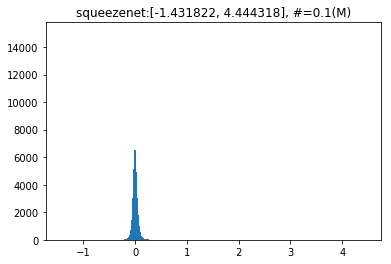

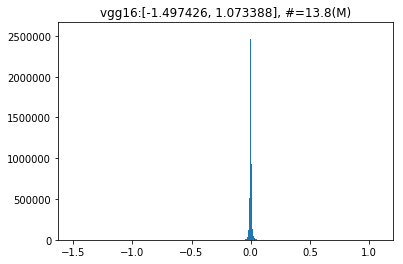

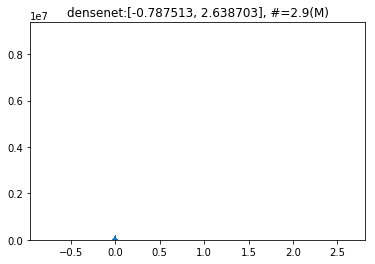

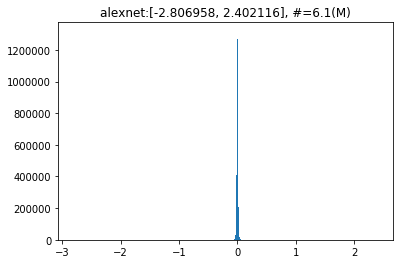

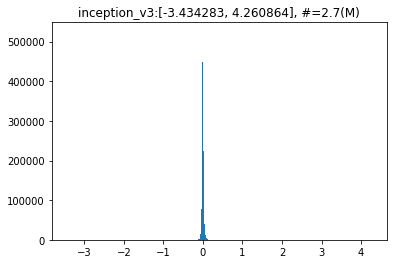

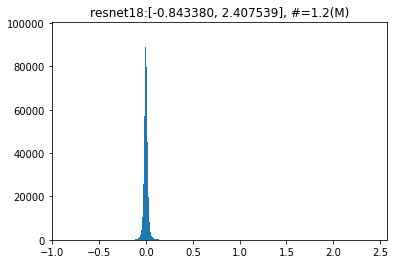

In [52]:
# check the weight distribution of other pre-trained models in torch vision
# import torchvision 

# pretrained_models = {'resnet18': torchvision.models.resnet18(pretrained=True),
#                      'alexnet': torchvision.models.alexnet(pretrained=True),
#                      'squeezenet': torchvision.models.squeezenet1_0(pretrained=True),
#                      'vgg16':  torchvision.models.vgg16(pretrained=True), 
#                      'densenet':  torchvision.models.densenet161(pretrained=True),
#                      'inception_v3':  torchvision.models.inception_v3(pretrained=True),
#                     }
# for model_name, pretrained_model in pretrained_models.items():
#     tensor = [param.data.cpu().numpy().ravel() for param in pretrained_model.parameters()]
#     tensor = np.concatenate(tensor)
#     minv, maxv = np.min(tensor), np.max(tensor)
#     num_values = tensor.shape[0]
#     plt.hist(tensor, bins=10000)
#     plt.title(model_name+ ':[%f, %f], #=%.1f(M)' %(minv, maxv, num_values/10e6))
#     plt.show()